In [1]:
import pandas as pd
import warnings
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.insert(0, root_dir)

from config import DATA_PATH

# Show all columns
pd.set_option('display.max_columns', None)

## Loading Necessary Libraries

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import missingno as msno

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, 'RTA Dataset.csv'))

print(df.shape)

(12316, 32)


In [4]:
df['Accident_severity'].value_counts()

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64

## Detect missing values

In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
df_missing = missing_values_table(df)
df_missing

Your selected dataframe has 32 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
Defect_of_vehicle,4427,35.9
Service_year_of_vehicle,3928,31.9
Work_of_casuality,3198,26.0
Fitness_of_casuality,2635,21.4
Type_of_vehicle,950,7.7
Types_of_Junction,887,7.2
Driving_experience,829,6.7
Educational_level,741,6.0
Vehicle_driver_relation,579,4.7
Owner_of_vehicle,482,3.9


**Types of Missing Data**
source:https://cjasn.asnjournals.org/content/early/2014/02/06/CJN.10141013/tab-figures-data?versioned=true

1. Missing Completely at Random (MCAR)

The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

2. Missing at Random (MAR)

MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

3. Missing Not at Random (MNAR)

Missingness depends on unobserved data or the value of the missing data itself.

All definitions taken from Wikipedia: https://en.wikipedia.org/wiki/Missing_data

Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.


<Axes: >

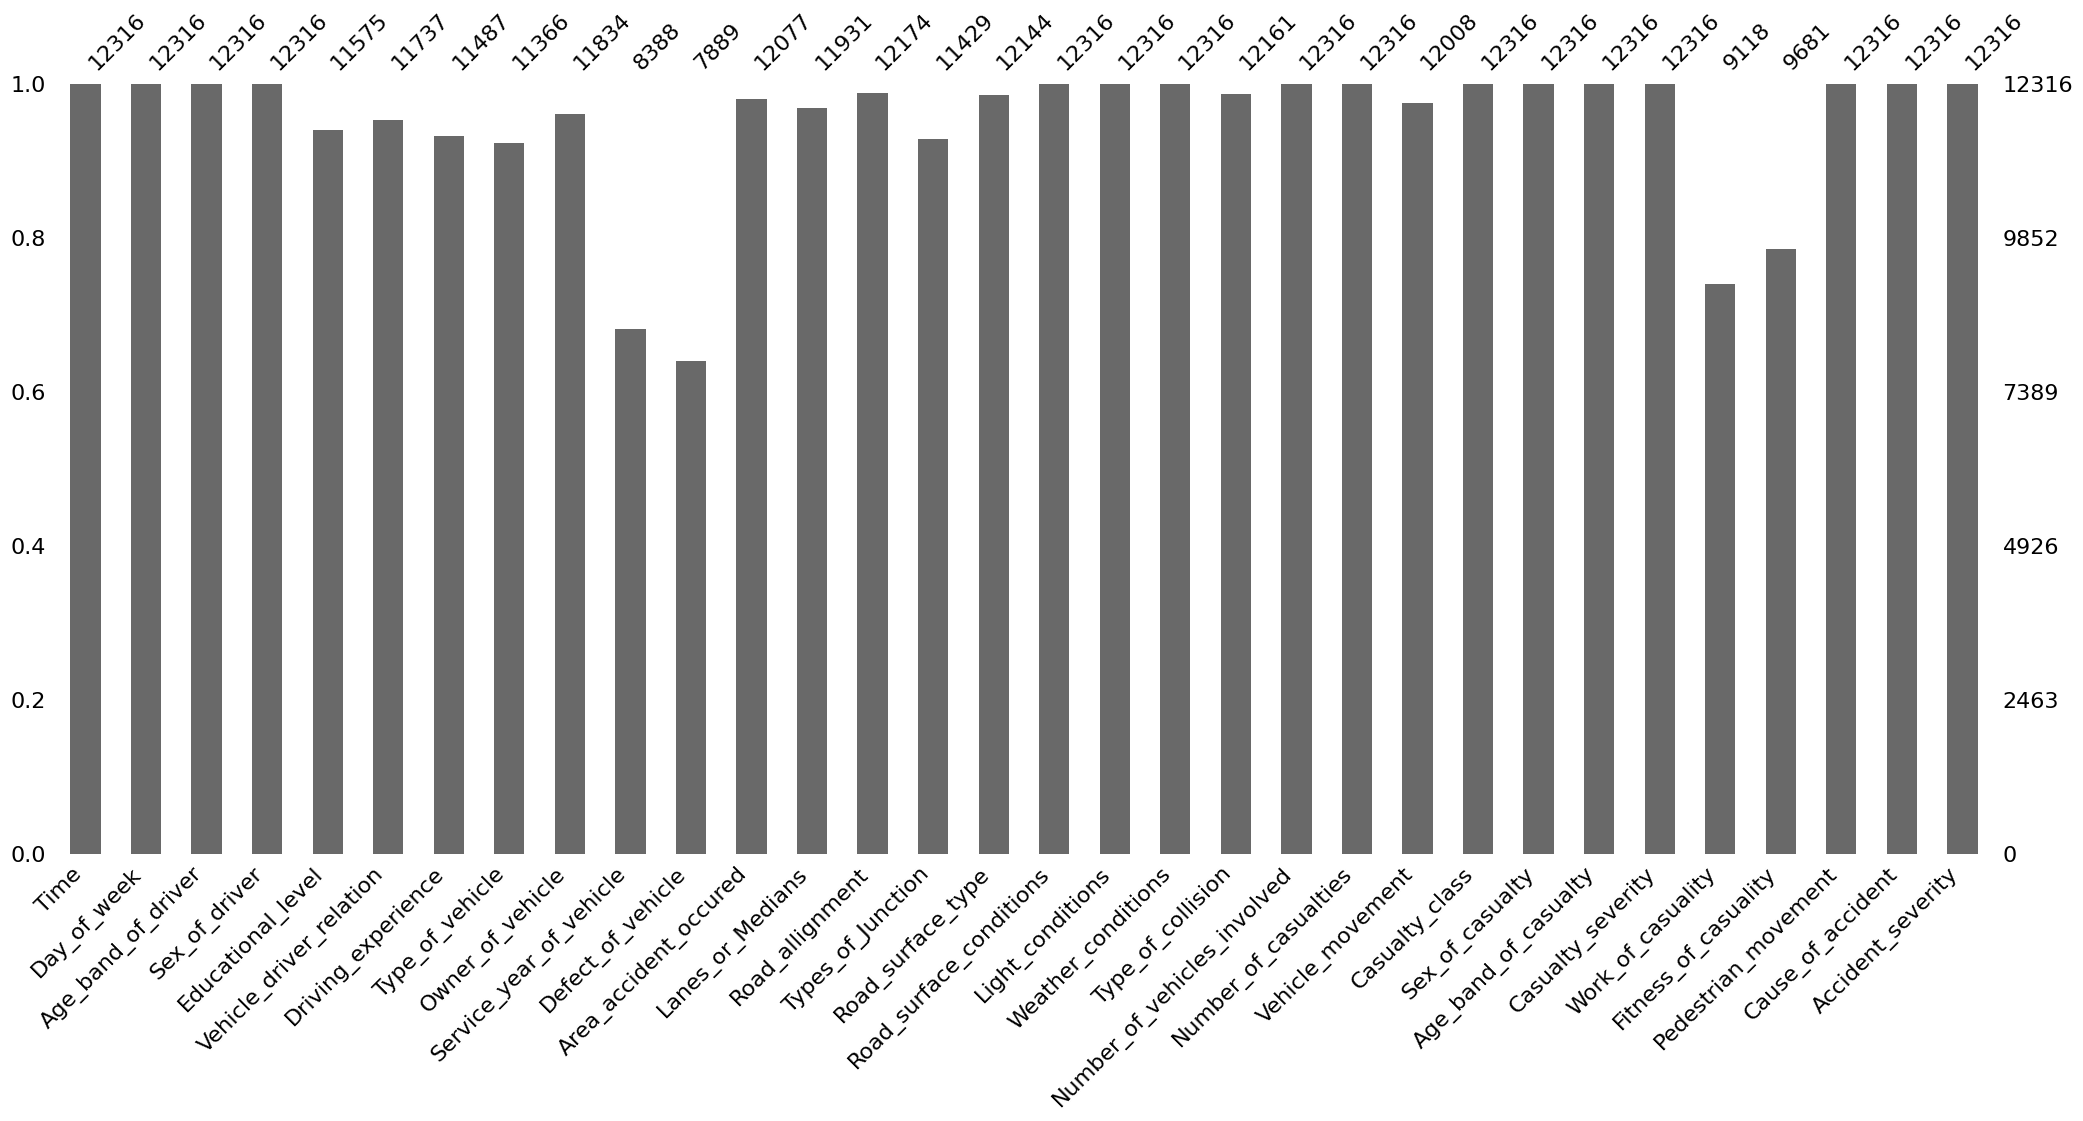

In [7]:
msno.bar(df)

<Axes: >

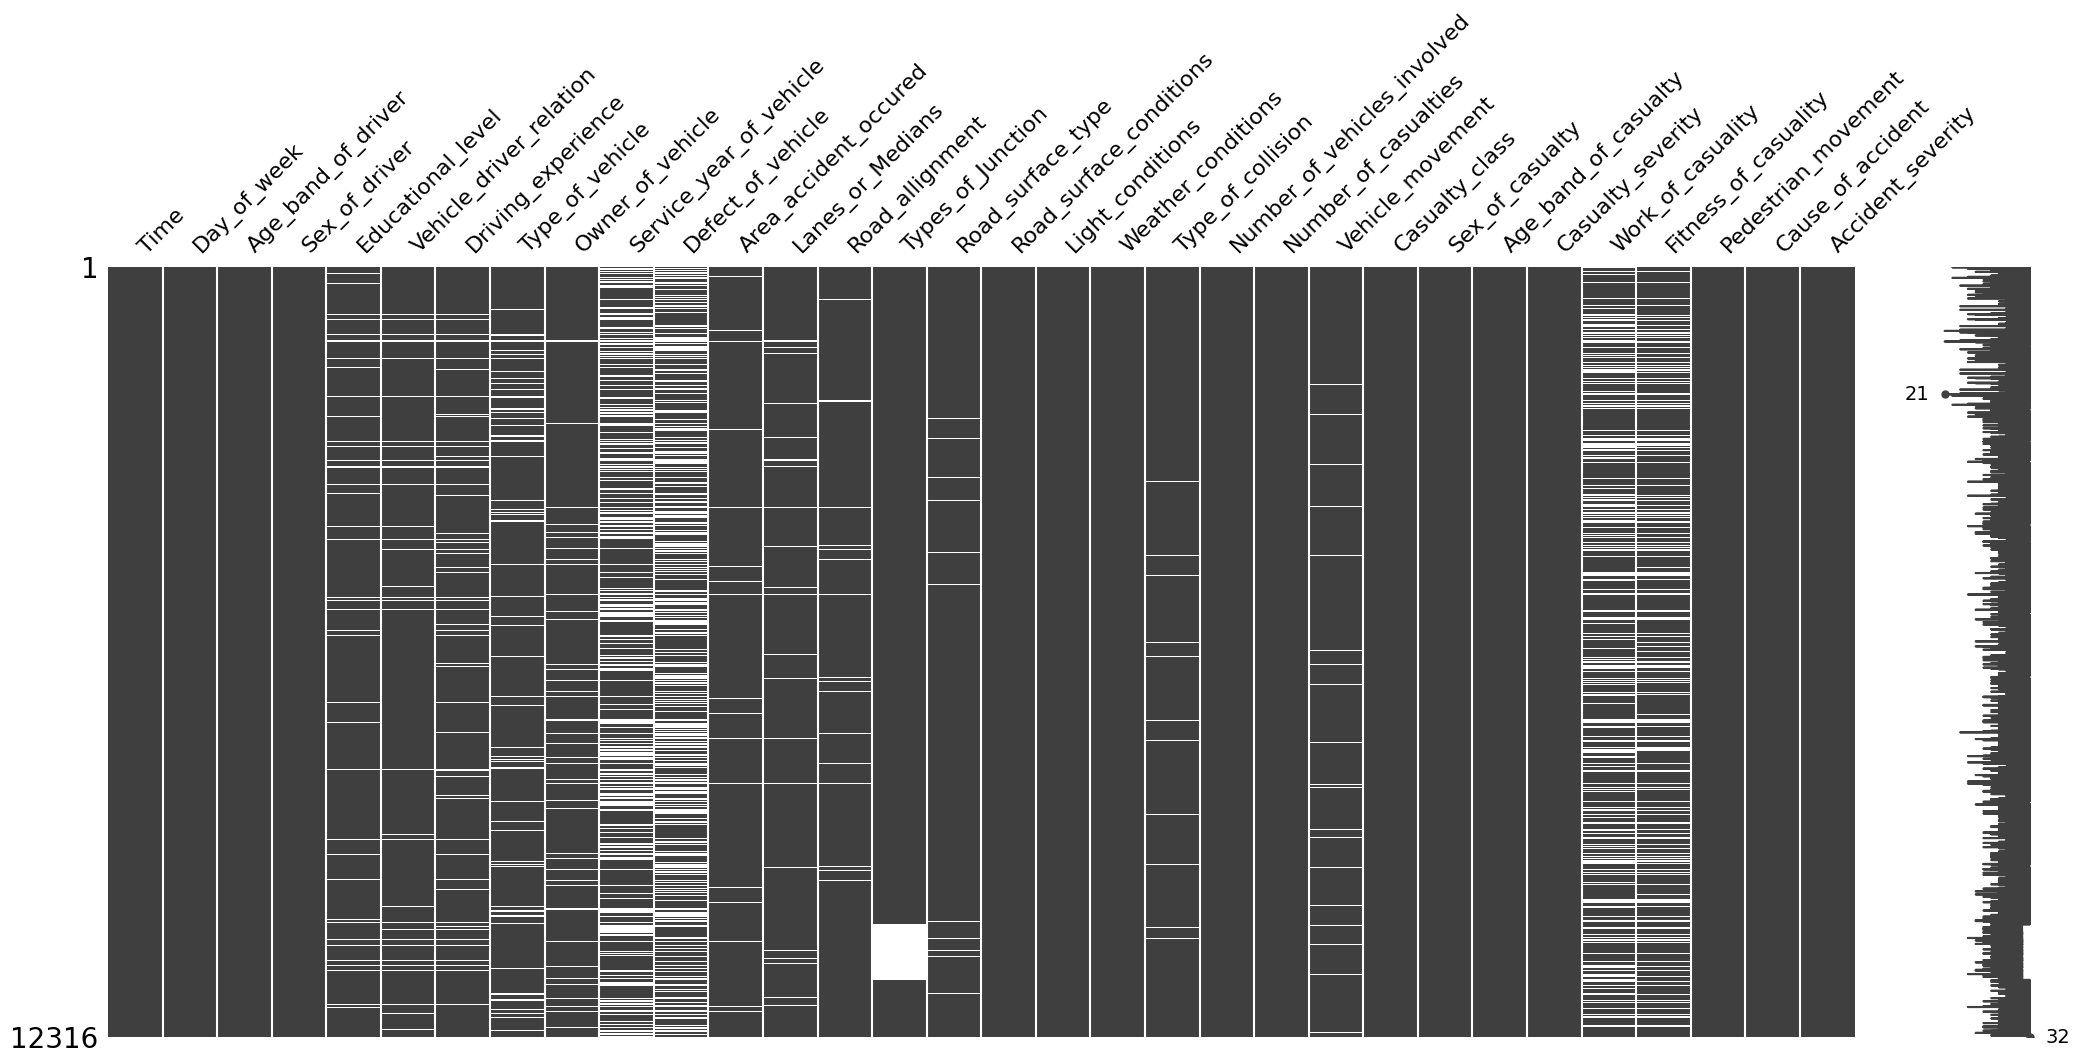

In [8]:
msno.matrix(df)

<Axes: >

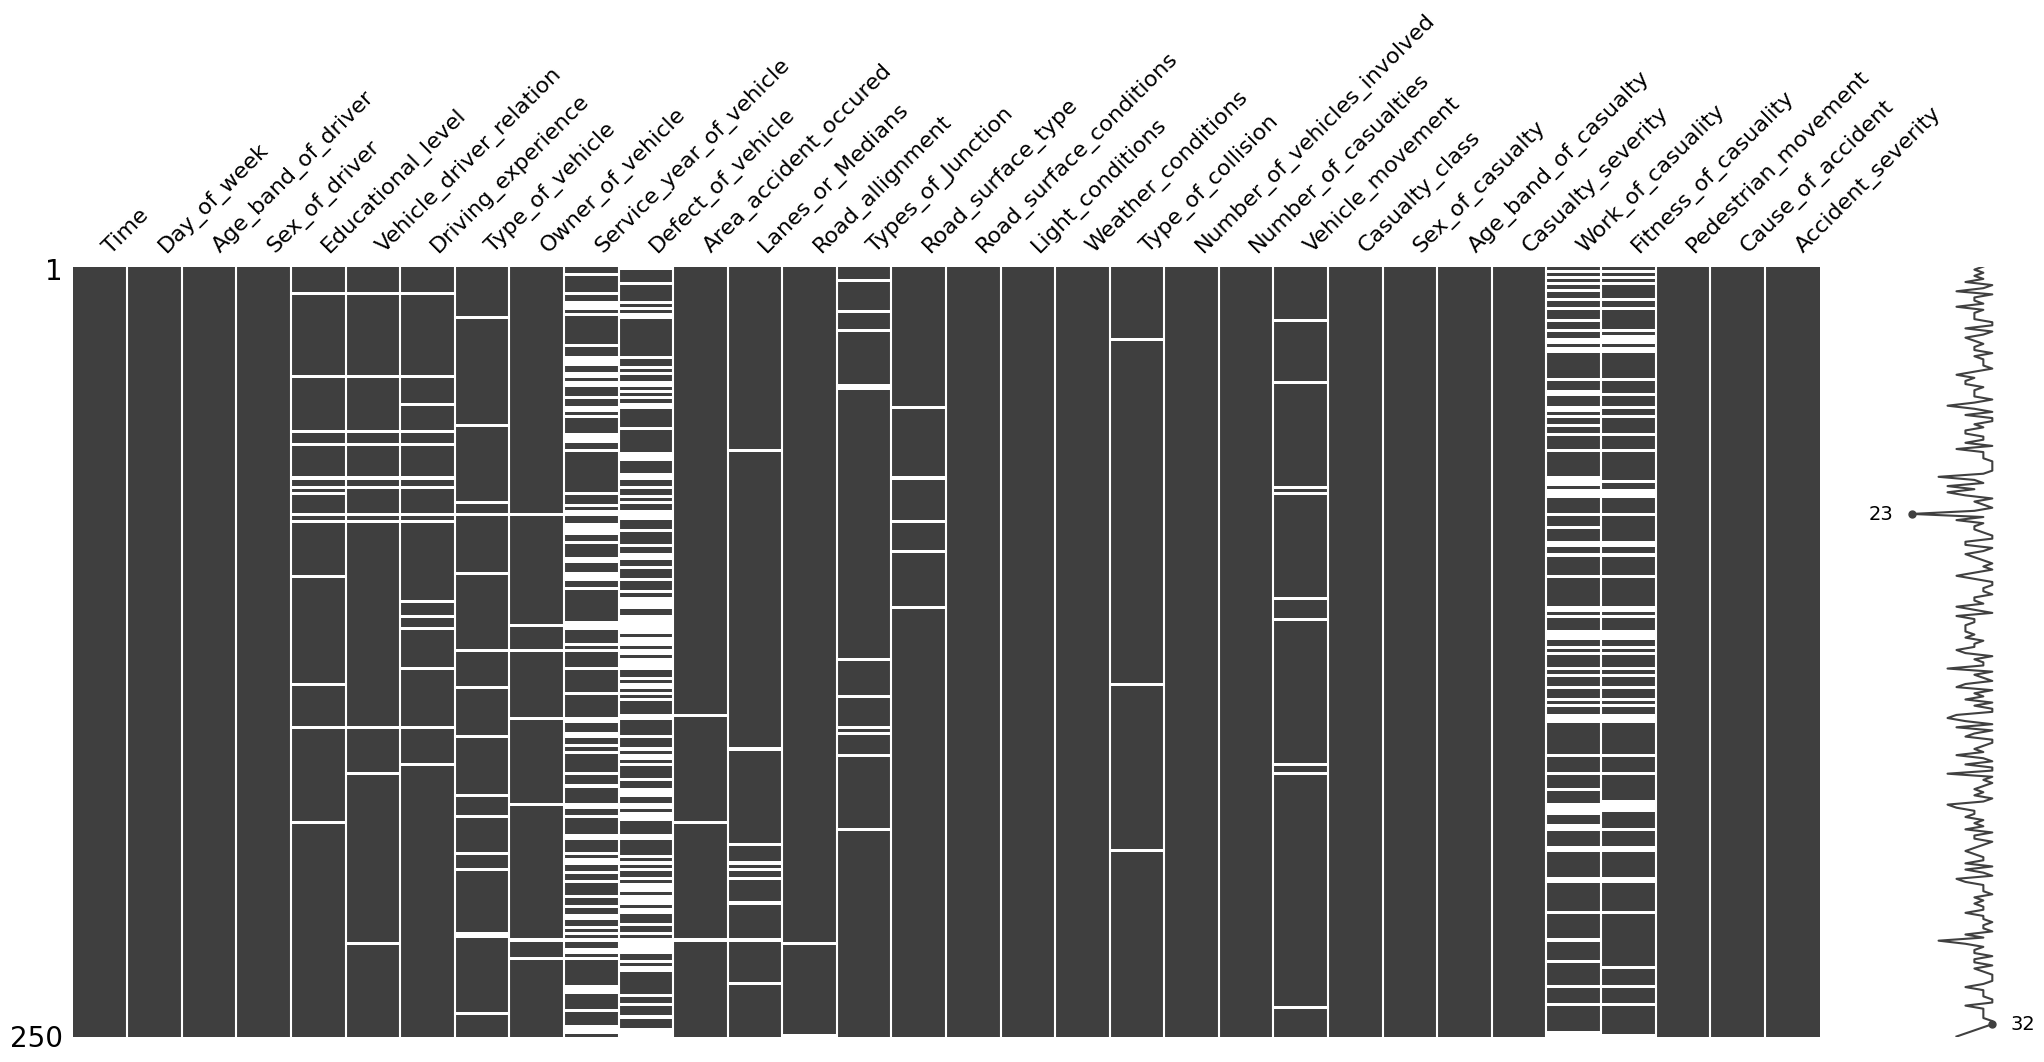

In [9]:
msno.matrix(df.sample(250))

## Finding reason for missing values

<Axes: >

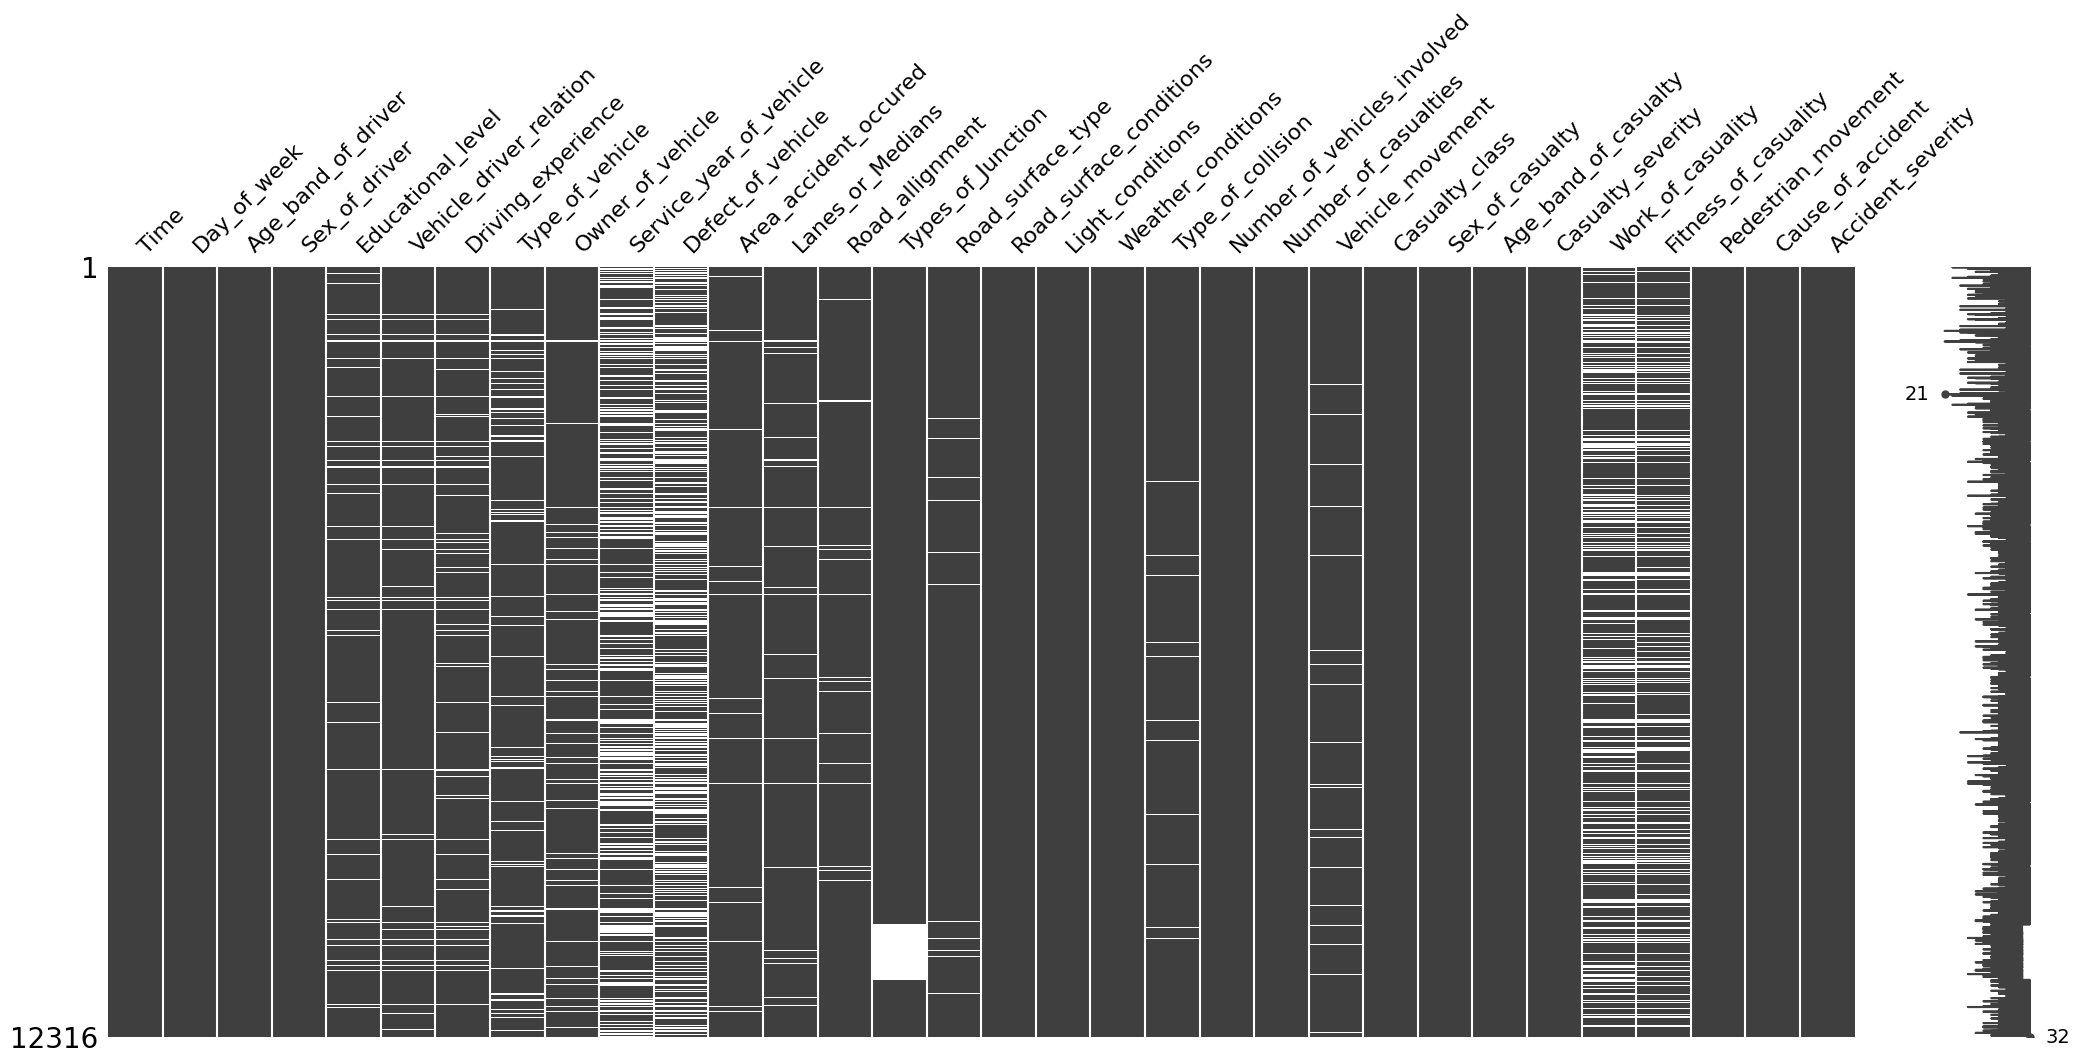

In [10]:
msno.matrix(df)

<Axes: >

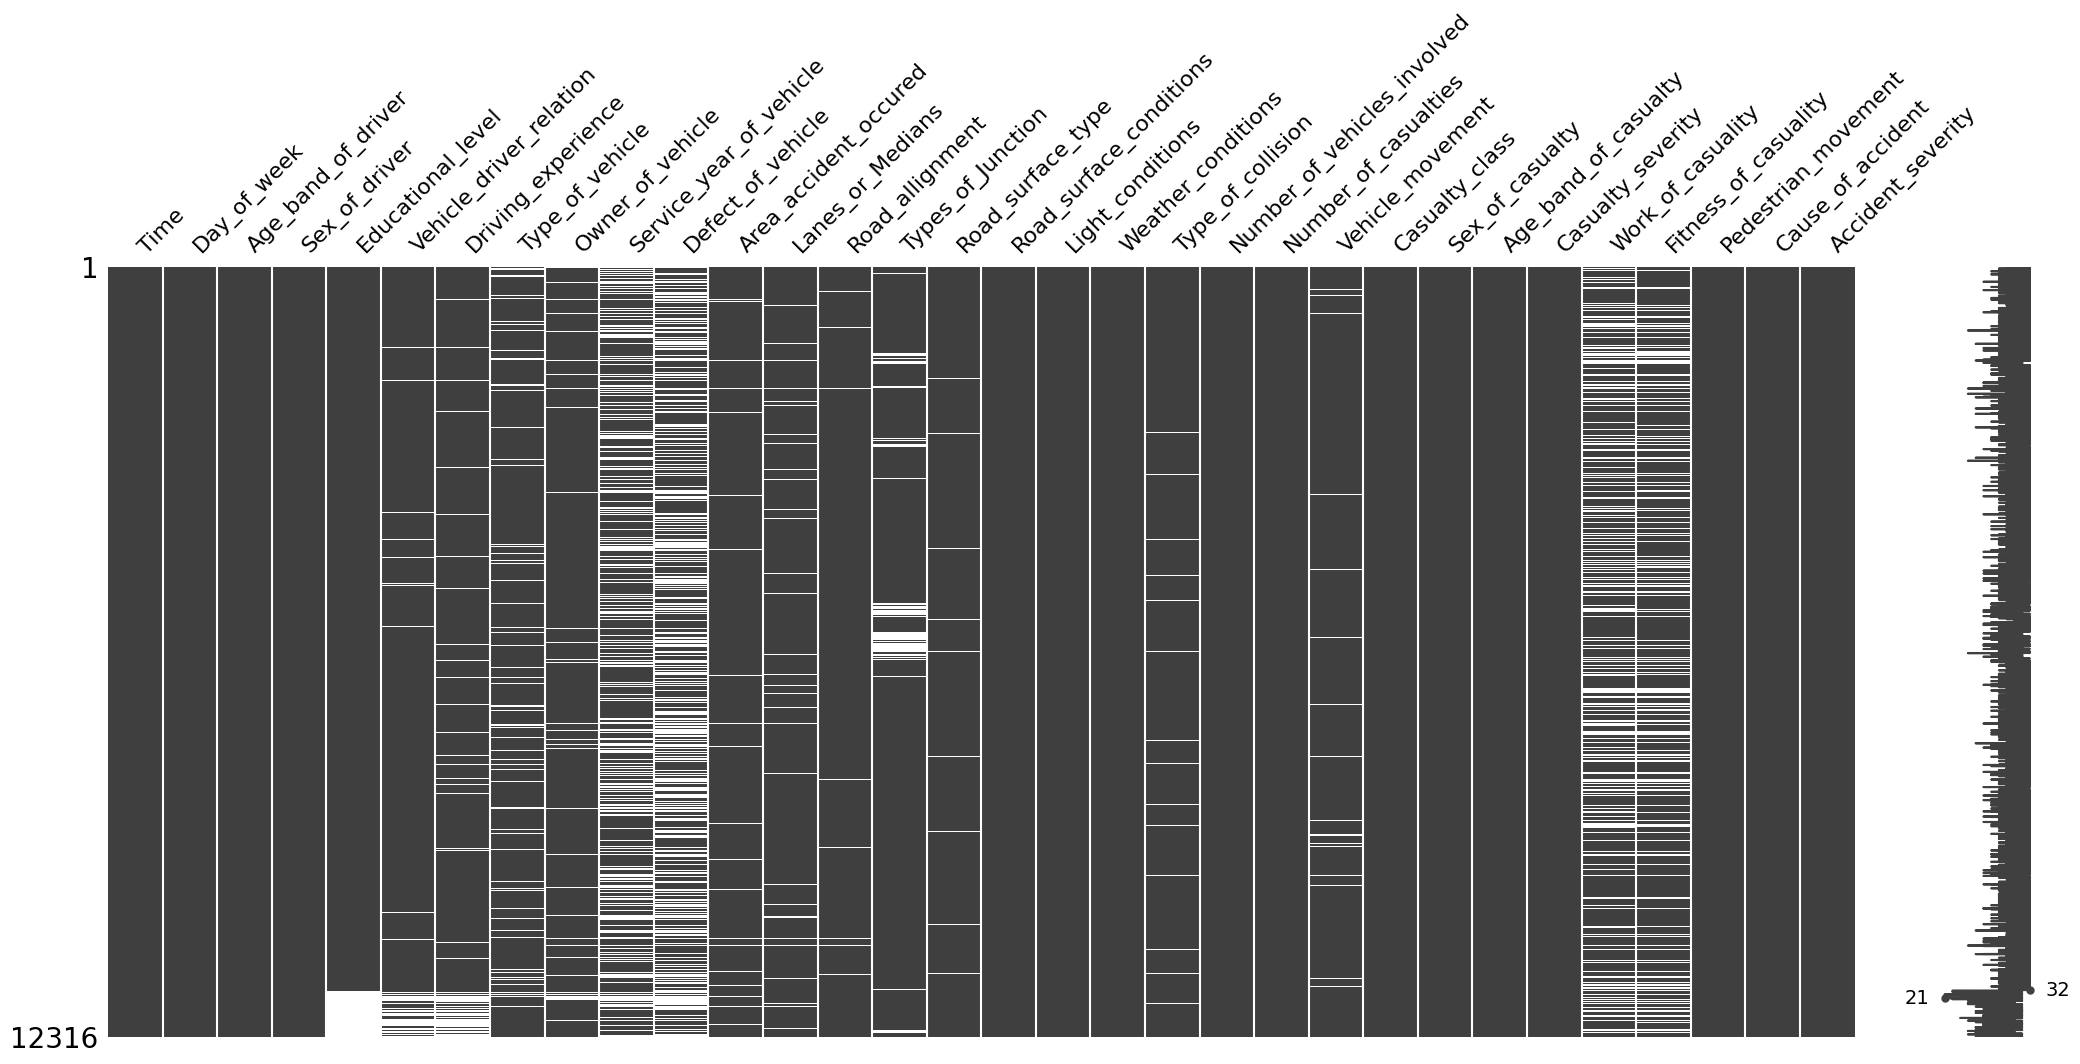

In [11]:
sorted_edu = df.sort_values('Educational_level')
msno.matrix(sorted_edu)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

<Axes: >

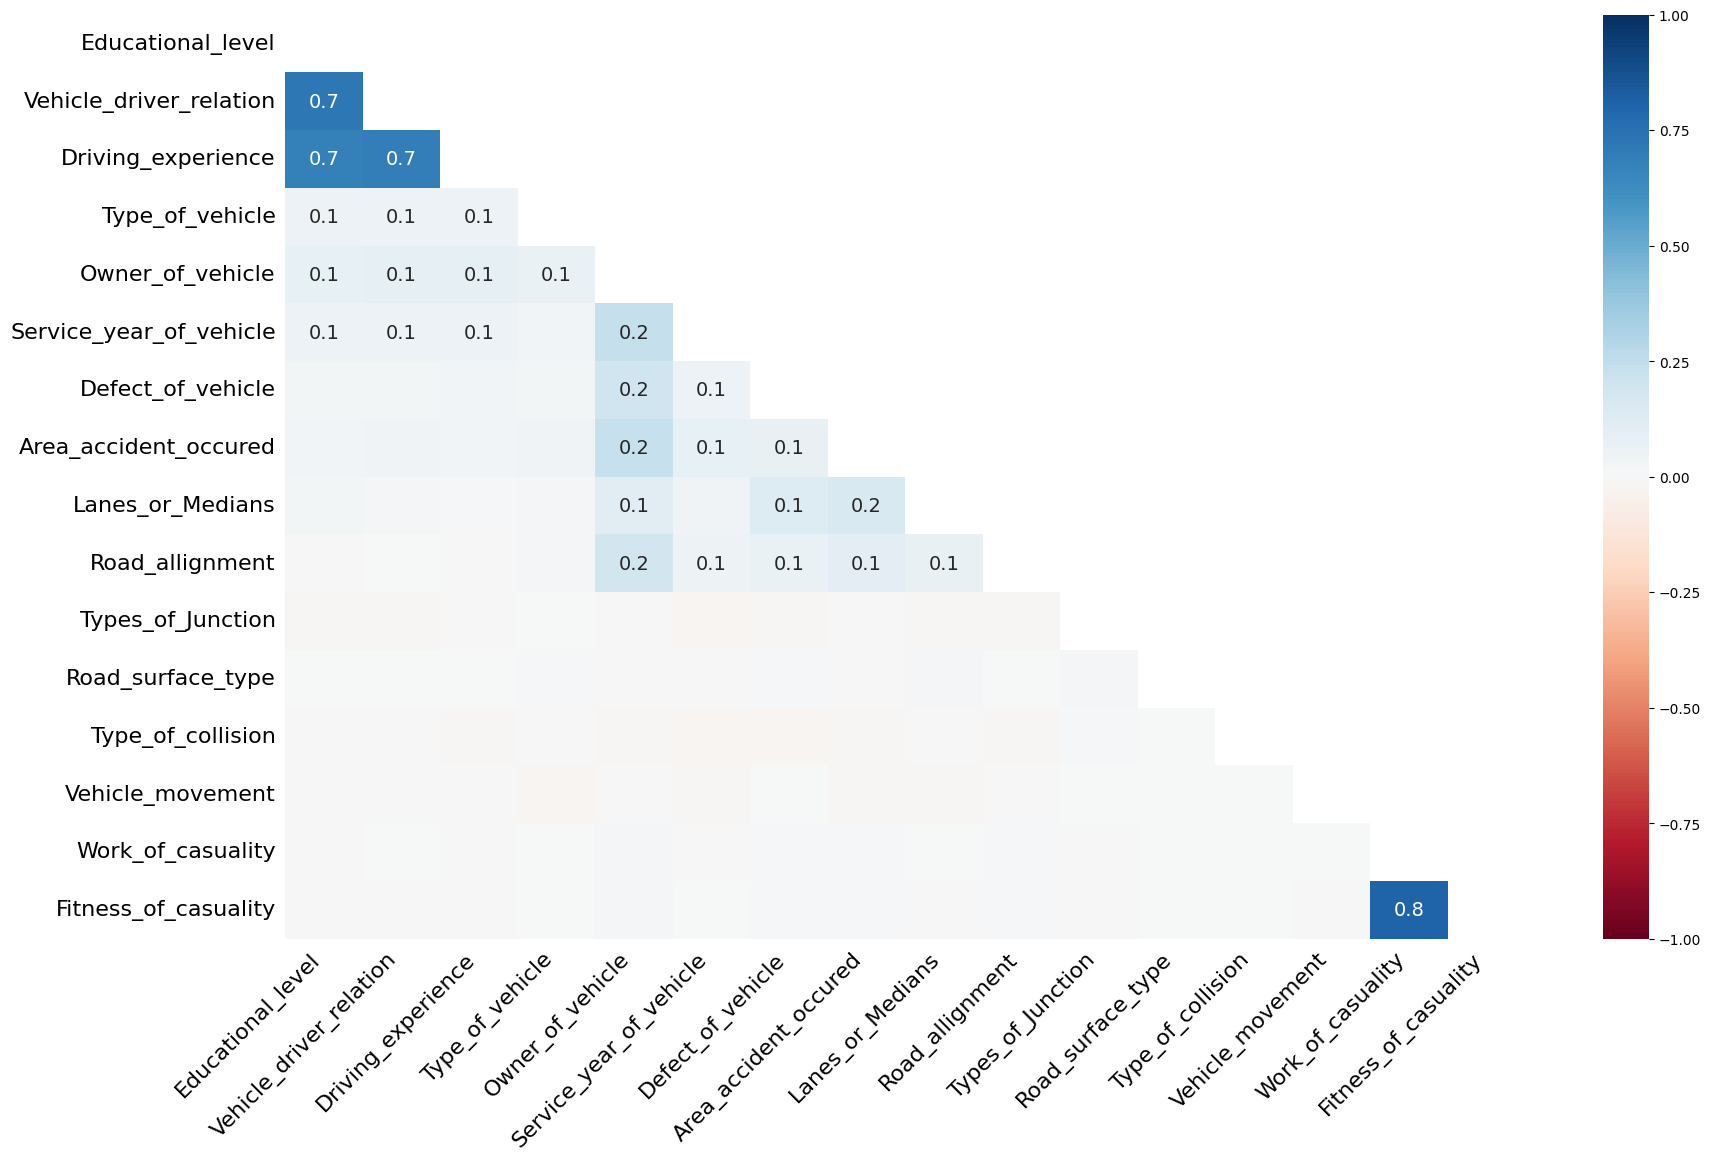

In [12]:
msno.heatmap(df)

A dendogram is a tree diagram of missingness. It groups the highly correlated variables together.



<Axes: >

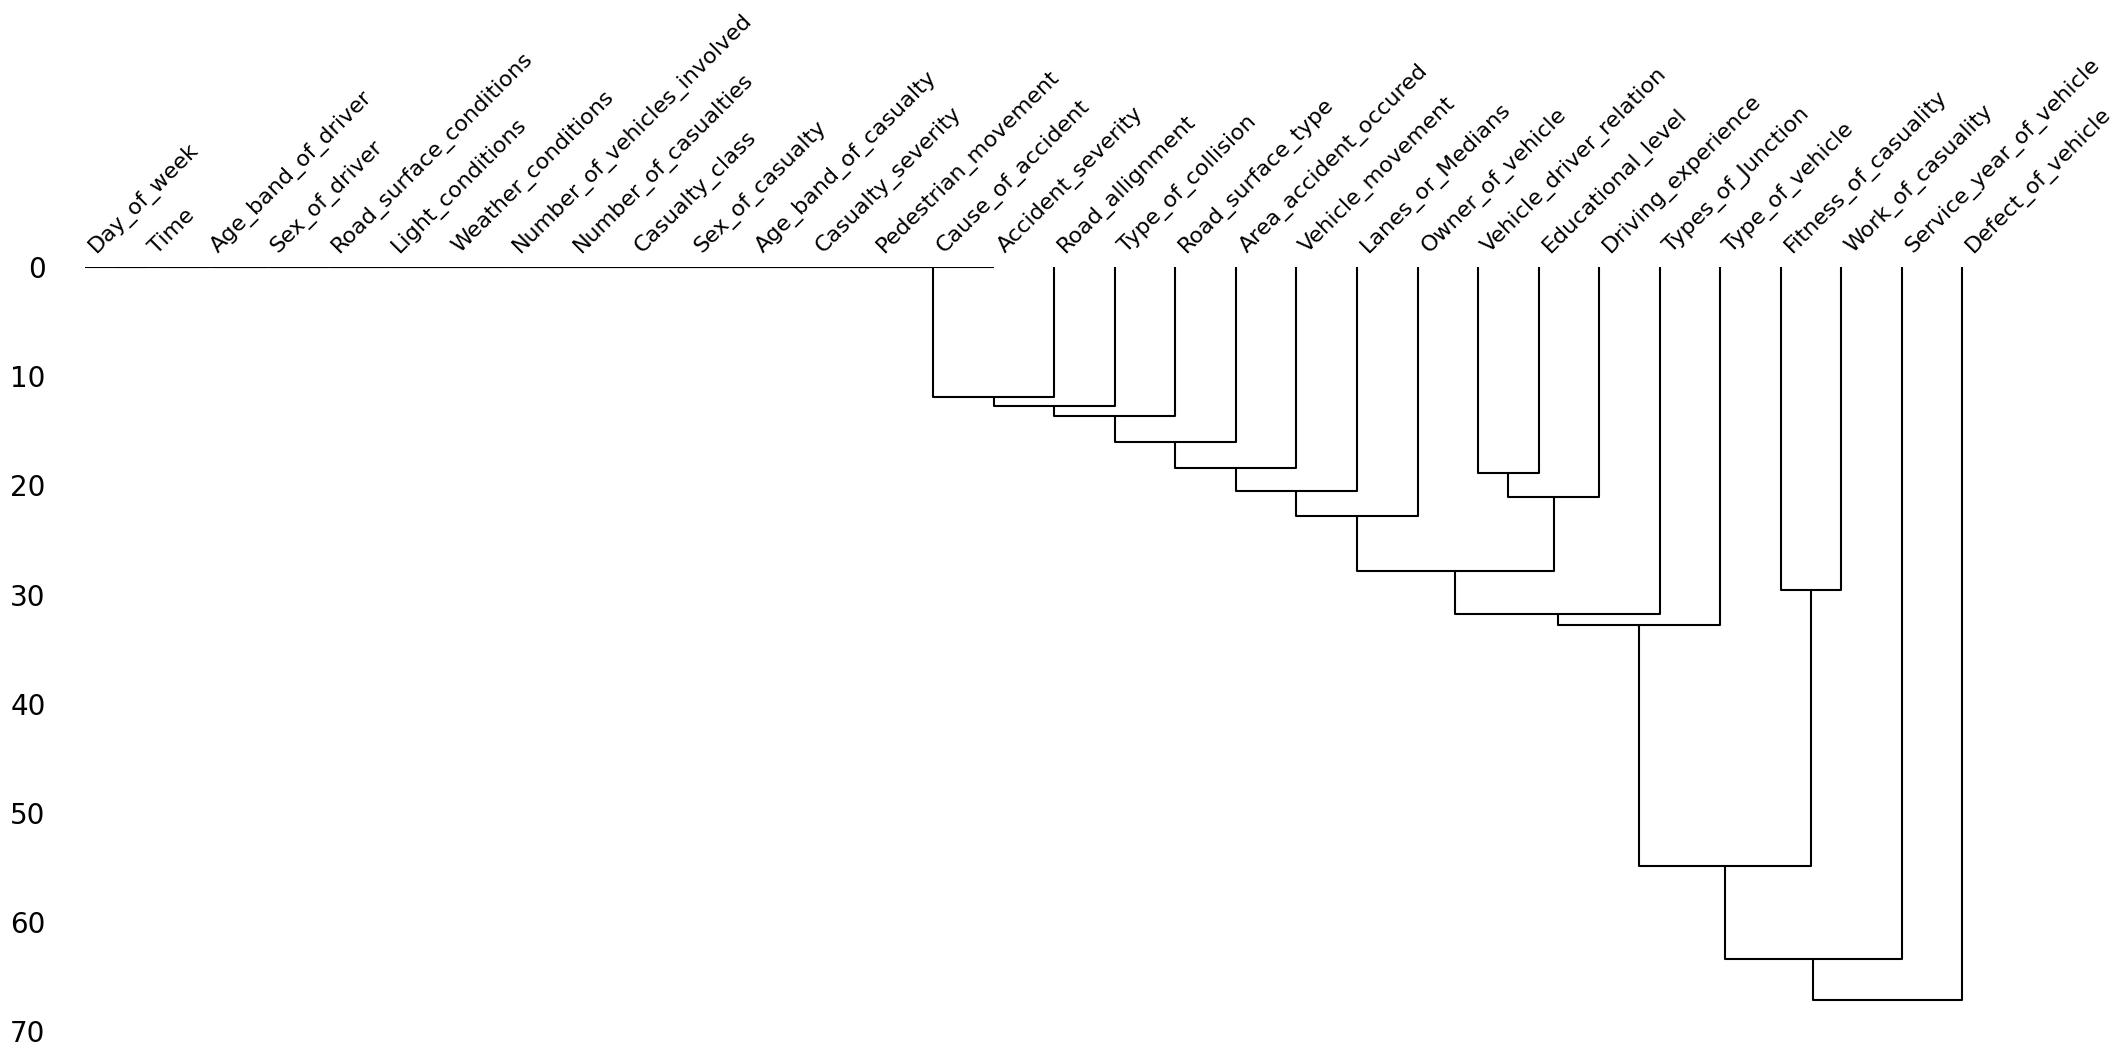

In [13]:
msno.dendrogram(df)

## Imputing using Random Forest

In [14]:
# Store columns with null values in a list
null_columns=df.columns[df.isnull().any()]

print(null_columns)

Index(['Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Type_of_collision', 'Vehicle_movement', 'Work_of_casuality',
       'Fitness_of_casuality'],
      dtype='object')


In [15]:
# Function to train RF model and impute missing values
def impute_rf(data, missing_feature):
    data_missing = data[data[missing_feature].isna()]
    data_no_missing = data.dropna(subset=[missing_feature])

    X = data_no_missing.drop(missing_feature, axis=1)
    y = data_no_missing[missing_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)

    data_missing_imputed = rf_clf.predict(data_missing.drop(missing_feature, axis=1))
    data_missing[missing_feature] = data_missing_imputed

    return pd.concat([data_no_missing, data_missing], axis=0)

In [16]:
df.head(3)

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury


In [17]:
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [18]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df.dtypes

Time                           object
Day_of_week                    object
Age_band_of_driver             object
Sex_of_driver                  object
Educational_level              object
Vehicle_driver_relation        object
Driving_experience             object
Type_of_vehicle                object
Owner_of_vehicle               object
Service_year_of_vehicle        object
Defect_of_vehicle              object
Area_accident_occured          object
Lanes_or_Medians               object
Road_allignment                object
Types_of_Junction              object
Road_surface_type              object
Road_surface_conditions        object
Light_conditions               object
Weather_conditions             object
Type_of_collision              object
Number_of_vehicles_involved     int64
Number_of_casualties            int64
Vehicle_movement               object
Casualty_class                 object
Sex_of_casualty                object
Age_band_of_casualty           object
Casualty_sev

In [19]:
clean_time_df = df.copy()
clean_time_df['Day_of_week'] = df['Day_of_week'].map({'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6})

In [20]:
clean_time_df['Day_of_week'].value_counts()

Day_of_week
5    2041
4    1851
3    1840
2    1770
1    1681
6    1666
0    1467
Name: count, dtype: int64

In [21]:
clean_time_df['Age_band_of_driver'].value_counts()

Age_band_of_driver
18-30       4271
31-50       4087
Over 51     1585
Unknown     1548
Under 18     825
Name: count, dtype: int64

In [22]:
clean_age_df = clean_time_df.copy()
clean_age_df['Age_band_of_driver'] = clean_time_df['Age_band_of_driver'].map({'Under 18': 0, '18-30': 1, '31-50': 2, 'Over 51': 3, 'Unknown': np.nan})
clean_age_df['Age_band_of_driver'].value_counts()

Age_band_of_driver
1.0    4271
2.0    4087
3.0    1585
0.0     825
Name: count, dtype: int64

In [23]:
clean_age_df['Sex_of_driver'].value_counts()

Sex_of_driver
Male       11437
Female       701
Unknown      178
Name: count, dtype: int64

In [24]:
clean_sex_df = clean_age_df.copy()
clean_sex_df['Sex_of_driver'] = clean_sex_df['Sex_of_driver'].replace('Unknown', np.nan)
clean_sex_df = pd.get_dummies(clean_sex_df, columns=['Sex_of_driver'])

In [25]:
clean_sex_df['Sex_of_driver_Female'].value_counts()

Sex_of_driver_Female
False    11615
True       701
Name: count, dtype: int64

In [26]:
# Convert boolean to int
clean_sex_df['Sex_of_driver_Female'] = clean_sex_df['Sex_of_driver_Female'].map({True: 1, False: 0})
clean_sex_df['Sex_of_driver_Male'] = clean_sex_df['Sex_of_driver_Male'].map({True: 1, False: 0})

In [27]:
clean_sex_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male
0,17:02:00,1,1.0,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1
1,17:02:00,1,2.0,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1
2,17:02:00,1,1.0,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1
3,01:06:00,0,1.0,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1
4,01:06:00,0,1.0,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1


In [28]:
clean_education_df = clean_sex_df.copy()
clean_education_df['Educational_level'] = clean_education_df['Educational_level'].replace('Unknown', np.nan)
clean_education_df['Educational_level'] = clean_education_df['Educational_level'].map({
    'Illiterate': 0,
    'Writing & reading': 1,
    'Elementary school': 2,
    'Junior high school': 3,
    'High school': 4,
    'Above high school': 5,
    'Unknown': np.nan
})

In [29]:
print(clean_education_df['Vehicle_driver_relation'].value_counts())
print(clean_education_df['Vehicle_driver_relation'].isnull().sum())

Vehicle_driver_relation
Employee    9627
Owner       1973
Other        123
Unknown       14
Name: count, dtype: int64
579


In [30]:
clean_vehicle_driver_df = clean_education_df.copy()
clean_vehicle_driver_df['Vehicle_driver_relation'] = clean_vehicle_driver_df['Vehicle_driver_relation'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_vehicle_driver_df[['Vehicle_driver_relation']])
clean_vehicle_driver_df['Vehicle_driver_relation'] = imputed_data.ravel()
clean_vehicle_driver_df = pd.get_dummies(clean_vehicle_driver_df, columns=['Vehicle_driver_relation'])
clean_vehicle_driver_df['Vehicle_driver_relation_Employee'] = clean_vehicle_driver_df['Vehicle_driver_relation_Employee'].map({True: 1, False: 0})
clean_vehicle_driver_df['Vehicle_driver_relation_Owner'] = clean_vehicle_driver_df['Vehicle_driver_relation_Owner'].map({True: 1, False: 0})
clean_vehicle_driver_df['Vehicle_driver_relation_Other'] = clean_vehicle_driver_df['Vehicle_driver_relation_Other'].map({True: 1, False: 0})

In [31]:
clean_vehicle_driver_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner
0,17:02:00,1,1.0,5.0,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0
1,17:02:00,1,2.0,3.0,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0
2,17:02:00,1,1.0,3.0,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0
3,01:06:00,0,1.0,3.0,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0
4,01:06:00,0,1.0,3.0,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0


In [32]:
clean_vehicle_driver_df['Driving_experience'].value_counts()

Driving_experience
5-10yr        3363
2-5yr         2613
Above 10yr    2262
1-2yr         1756
Below 1yr     1342
No Licence     118
unknown         33
Name: count, dtype: int64

In [33]:
clean_driving_experience_df = clean_vehicle_driver_df.copy()
clean_driving_experience_df['Driving_experience'] = clean_driving_experience_df['Driving_experience'].replace('unknown', np.nan)
clean_driving_experience_df['Driving_experience'] = clean_driving_experience_df['Driving_experience'].map({
    'No Licence': 0,
    'Below 1yr': 1,
    '1-2yr': 2,
    '2-5yr': 3,
    '5-10yr': 4,
    'Above 10yr': 5,
})

clean_driving_experience_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner
0,17:02:00,1,1.0,5.0,2.0,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0
1,17:02:00,1,2.0,3.0,5.0,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0
2,17:02:00,1,1.0,3.0,2.0,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0
3,01:06:00,0,1.0,3.0,4.0,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0
4,01:06:00,0,1.0,3.0,3.0,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0


In [34]:
print(clean_driving_experience_df['Type_of_vehicle'].value_counts())
print(clean_driving_experience_df['Type_of_vehicle'].isnull().sum())

Type_of_vehicle
Automobile              3205
Lorry (41?100Q)         2186
Other                   1208
Pick up upto 10Q         811
Public (12 seats)        711
Stationwagen             687
Lorry (11?40Q)           541
Public (13?45 seats)     532
Public (> 45 seats)      404
Long lorry               383
Taxi                     265
Motorcycle               177
Special vehicle           84
Ridden horse              76
Turbo                     46
Bajaj                     29
Bicycle                   21
Name: count, dtype: int64
950


In [35]:
clean_vehicle_type_df = clean_driving_experience_df.copy()
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_vehicle_type_df[['Type_of_vehicle']])
clean_vehicle_type_df['Type_of_vehicle'] = imputed_data.ravel()
clean_vehicle_type_df = pd.get_dummies(clean_vehicle_type_df, columns=['Type_of_vehicle'])

In [36]:
# Find columns that start with 'Type_of_vehicle'
vehicle_type_cols = [col for col in clean_vehicle_type_df.columns if col.startswith('Type_of_vehicle')]
# Convert boolean to int
for col in vehicle_type_cols:
    clean_vehicle_type_df[col] = clean_vehicle_type_df[col].map({True: 1, False: 0})

In [37]:
clean_vehicle_type_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo
0,17:02:00,1,1.0,5.0,2.0,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,17:02:00,1,1.0,3.0,2.0,Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,01:06:00,0,1.0,3.0,4.0,Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,01:06:00,0,1.0,3.0,3.0,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
print(clean_vehicle_type_df['Owner_of_vehicle'].value_counts())
print(clean_vehicle_type_df['Owner_of_vehicle'].isnull().sum())

Owner_of_vehicle
Owner           10459
Governmental     1041
Organization      312
Other              22
Name: count, dtype: int64
482


In [39]:
clean_owner_df = clean_vehicle_type_df.copy()
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_owner_df[['Owner_of_vehicle']])
clean_owner_df['Owner_of_vehicle'] = imputed_data.ravel()
clean_owner_df = pd.get_dummies(clean_owner_df, columns=['Owner_of_vehicle'])

# Find columns that start with 'Owner_of_vehicle'
owner_cols = [col for col in clean_owner_df.columns if col.startswith('Owner_of_vehicle')]
# Convert boolean to int
for col in owner_cols:
    clean_owner_df[col] = clean_owner_df[col].map({True: 1, False: 0})

In [40]:
print(clean_owner_df['Service_year_of_vehicle'].value_counts())
print(clean_owner_df['Service_year_of_vehicle'].isnull().sum())

Service_year_of_vehicle
Unknown       2883
2-5yrs        1792
Above 10yr    1324
5-10yrs       1280
1-2yr          827
Below 1yr      282
Name: count, dtype: int64
3928


In [41]:
clean_service_year_df = clean_owner_df.copy()
clean_service_year_df['Service_year_of_vehicle'] = clean_service_year_df['Service_year_of_vehicle'].replace('Unknown', np.nan)
clean_service_year_df['Service_year_of_vehicle'] = clean_service_year_df['Service_year_of_vehicle'].map({
    'Below 1yr': 0,
    '1-2yr': 1,
    '2-5yrs': 2,
    '5-10yrs': 3,
    'Above 10yr': 4,
})

In [42]:
clean_service_year_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner
0,17:02:00,1,1.0,5.0,2.0,4.0,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,17:02:00,1,2.0,3.0,5.0,3.0,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,17:02:00,1,1.0,3.0,2.0,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,01:06:00,0,1.0,3.0,4.0,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [43]:
print(clean_service_year_df['Defect_of_vehicle'].value_counts())
print(clean_service_year_df['Defect_of_vehicle'].isnull().sum())

Defect_of_vehicle
No defect    7777
7              76
5              36
Name: count, dtype: int64
4427


In [44]:
clean_num_defects_df = clean_service_year_df.copy()
clean_num_defects_df['Defect_of_vehicle'] = clean_num_defects_df['Defect_of_vehicle'].replace('No defect', 0)

In [45]:
print(clean_num_defects_df['Defect_of_vehicle'].value_counts())
print(clean_num_defects_df['Defect_of_vehicle'].isnull().sum())

Defect_of_vehicle
0    7777
7      76
5      36
Name: count, dtype: int64
4427


In [46]:
clean_num_defects_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
print(clean_num_defects_df['Area_accident_occured'].value_counts())
print(clean_num_defects_df['Area_accident_occured'].isnull().sum())

Area_accident_occured
Other                              3819
Office areas                       3451
Residential areas                  2060
 Church areas                      1060
 Industrial areas                   456
School areas                        415
  Recreational areas                327
 Outside rural areas                218
 Hospital areas                     121
  Market areas                       63
Rural village areas                  44
Unknown                              22
Rural village areasOffice areas      20
Recreational areas                    1
Name: count, dtype: int64
239


In [48]:
clean_area_accident_df = clean_num_defects_df.copy()
clean_area_accident_df['Area_accident_occured'] = clean_area_accident_df['Area_accident_occured'].replace('Unknown', np.nan)
clean_area_accident_df['Area_accident_occured'] = clean_area_accident_df['Area_accident_occured'].map({
    ' Church areas': 'Church areas',
    ' Industrial areas': 'Industrial areas',
    '  Recreational areas': 'Recreational areas',
    ' Outside rural areas': 'Outside rural areas',
    ' Hospital areas': 'Hospital areas',
    '  Market areas': 'Market areas',
    'Rural village areasOffice areas': 'Rural village areas'
})
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_area_accident_df[['Area_accident_occured']])
clean_area_accident_df['Area_accident_occured'] = imputed_data.ravel()
clean_area_accident_df = pd.get_dummies(clean_area_accident_df, columns=['Area_accident_occured'])

In [49]:
area_accident_cols = [col for col in clean_area_accident_df.columns if col.startswith('Area_accident_occured')]
for col in area_accident_cols:
    clean_area_accident_df[col] = clean_area_accident_df[col].map({True: 1, False: 0})

In [50]:
clean_area_accident_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas
0,17:02:00,1,1.0,5.0,2.0,4.0,0,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [51]:
print(clean_area_accident_df['Lanes_or_Medians'].value_counts())
print(clean_area_accident_df['Lanes_or_Medians'].isnull().sum())

Lanes_or_Medians
Two-way (divided with broken lines road marking)    4411
Undivided Two way                                   3796
other                                               1660
Double carriageway (median)                         1020
One way                                              845
Two-way (divided with solid lines road marking)      142
Unknown                                               57
Name: count, dtype: int64
385


In [52]:
clean_lanes_df = clean_area_accident_df.copy()
clean_lanes_df['Lanes_or_Medians'] = clean_lanes_df['Lanes_or_Medians'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_lanes_df[['Lanes_or_Medians']])
clean_lanes_df['Lanes_or_Medians'] = imputed_data.ravel()
clean_lanes_df = pd.get_dummies(clean_lanes_df, columns=['Lanes_or_Medians'])

lanes_cols = [col for col in clean_lanes_df.columns if col.startswith('Lanes_or_Medians')]
for col in lanes_cols:
    clean_lanes_df[col] = clean_lanes_df[col].map({True: 1, False: 0})

In [53]:
clean_lanes_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [54]:
print(clean_lanes_df['Road_allignment'].value_counts())
print(clean_lanes_df['Road_allignment'].isnull().sum())

Road_allignment
Tangent road with flat terrain                   10459
Tangent road with mild grade and flat terrain      501
Steep grade downward with mountainous terrain      429
Tangent road with mountainous terrain and          396
Gentle horizontal curve                            163
Escarpments                                        113
Sharp reverse curve                                 57
Tangent road with rolling terrain                   37
Steep grade upward with mountainous terrain         19
Name: count, dtype: int64
142


In [55]:
clean_road_allignment_df = clean_lanes_df.copy()
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_road_allignment_df[['Road_allignment']])
clean_road_allignment_df['Road_allignment'] = imputed_data.ravel()
clean_road_allignment_df = pd.get_dummies(clean_road_allignment_df, columns=['Road_allignment'])

road_allignment_cols = [col for col in clean_road_allignment_df.columns if col.startswith('Road_allignment')]
for col in road_allignment_cols:
    clean_road_allignment_df[col] = clean_road_allignment_df[col].map({True: 1, False: 0})

In [56]:
clean_road_allignment_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain
0,17:02:00,1,1.0,5.0,2.0,4.0,0,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [57]:
print(clean_road_allignment_df['Types_of_Junction'].value_counts())
print(clean_road_allignment_df['Types_of_Junction'].isnull().sum())

Types_of_Junction
Y Shape        4543
No junction    3837
Crossing       2177
Other           445
Unknown         191
O Shape         164
T Shape          60
X Shape          12
Name: count, dtype: int64
887


In [58]:
clean_type_junction_df = clean_road_allignment_df.copy()
clean_type_junction_df['Types_of_Junction'] = clean_type_junction_df['Types_of_Junction'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_type_junction_df[['Types_of_Junction']])
clean_type_junction_df['Types_of_Junction'] = imputed_data.ravel()
clean_type_junction_df = pd.get_dummies(clean_type_junction_df, columns=['Types_of_Junction'])

type_junction_cols = [col for col in clean_type_junction_df.columns if col.startswith('Types_of_Junction')]
for col in type_junction_cols:
    clean_type_junction_df[col] = clean_type_junction_df[col].map({True: 1, False: 0})

In [59]:
clean_type_junction_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [60]:
print(clean_type_junction_df['Road_surface_type'].value_counts())
print(clean_type_junction_df['Road_surface_type'].isnull().sum())

Road_surface_type
Asphalt roads                       11296
Earth roads                           358
Gravel roads                          242
Other                                 167
Asphalt roads with some distress       81
Name: count, dtype: int64
172


In [61]:
clean_road_surface_df = clean_type_junction_df.copy()
clean_road_surface_df['Road_surface_type'] = clean_road_surface_df['Road_surface_type'].replace('Asphalt roads with some distress', 'Asphalt roads')
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_road_surface_df[['Road_surface_type']])
clean_road_surface_df['Road_surface_type'] = imputed_data.ravel()
clean_road_surface_df = pd.get_dummies(clean_road_surface_df, columns=['Road_surface_type'])

road_surface_cols = [col for col in clean_road_surface_df.columns if col.startswith('Road_surface_type')]
for col in road_surface_cols:
    clean_road_surface_df[col] = clean_road_surface_df[col].map({True: 1, False: 0})

clean_road_surface_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [62]:
print(clean_road_surface_df['Road_surface_conditions'].value_counts())
print(clean_road_surface_df['Road_surface_conditions'].isnull().sum())

Road_surface_conditions
Dry                     9340
Wet or damp             2904
Snow                      70
Flood over 3cm. deep       2
Name: count, dtype: int64
0


In [63]:
clean_road_conditions_df = clean_road_surface_df.copy()
clean_road_conditions_df = pd.get_dummies(clean_road_conditions_df, columns=['Road_surface_conditions'])

road_conditions_cols = [col for col in clean_road_conditions_df.columns if col.startswith('Road_surface_conditions')]
for col in road_conditions_cols:
    clean_road_conditions_df[col] = clean_road_conditions_df[col].map({True: 1, False: 0})

clean_road_conditions_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [64]:
print(clean_road_conditions_df['Light_conditions'].value_counts())
print(clean_road_conditions_df['Light_conditions'].isnull().sum())

Light_conditions
Daylight                   8798
Darkness - lights lit      3286
Darkness - no lighting      192
Darkness - lights unlit      40
Name: count, dtype: int64
0


In [65]:
clean_light_conditions_df = clean_road_conditions_df.copy()
clean_light_conditions_df = pd.get_dummies(clean_light_conditions_df, columns=['Light_conditions'])

light_conditions_cols = [col for col in clean_light_conditions_df.columns if col.startswith('Light_conditions')]
for col in light_conditions_cols:
    clean_light_conditions_df[col] = clean_light_conditions_df[col].map({True: 1, False: 0})

clean_light_conditions_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0
4,01:06:00,0,1.0,3.0,3.0,3.0,0,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,No

In [66]:
print(clean_light_conditions_df['Weather_conditions'].value_counts())
print(clean_light_conditions_df['Weather_conditions'].isnull().sum())

Weather_conditions
Normal               10063
Raining               1331
Other                  296
Unknown                292
Cloudy                 125
Windy                   98
Snow                    61
Raining and Windy       40
Fog or mist             10
Name: count, dtype: int64
0


In [67]:
clean_weather_conditions_df = clean_light_conditions_df.copy()
clean_weather_conditions_df['Weather_conditions'] = clean_weather_conditions_df['Weather_conditions'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_weather_conditions_df[['Weather_conditions']])
clean_weather_conditions_df['Weather_conditions'] = imputed_data.ravel()
clean_weather_conditions_df = pd.get_dummies(clean_weather_conditions_df, columns=['Weather_conditions'])

weather_conditions_cols = [col for col in clean_weather_conditions_df.columns if col.startswith('Weather_conditions')]
for col in weather_conditions_cols:
    clean_weather_conditions_df[col] = clean_weather_conditions_df[col].map({True: 1, False: 0})

clean_weather_conditions_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight,Weather_conditions_Cloudy,Weather_conditions_Fog or mist,Weather_conditions_Normal,Weather_conditions_Other,Weather_conditions_Raining,Weather_conditions_Raining and Windy,Weather_conditions_Snow,Weather_conditions_Windy
0,17:02:00,1,1.0,5.0,2.0,4.0,0,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,01:06:00,0,1.0,3.0,4.0,NaN,0,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,

In [68]:
print(clean_weather_conditions_df['Type_of_collision'].value_counts())
print(clean_weather_conditions_df['Type_of_collision'].isnull().sum())

Type_of_collision
Vehicle with vehicle collision             8774
Collision with roadside objects            1786
Collision with pedestrians                  896
Rollover                                    397
Collision with animals                      171
Collision with roadside-parked vehicles      54
Fall from vehicles                           34
Other                                        26
Unknown                                      14
With Train                                    9
Name: count, dtype: int64
155


In [69]:
clean_type_collision_df = clean_weather_conditions_df.copy()
clean_type_collision_df['Type_of_collision'] = clean_type_collision_df['Type_of_collision'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_type_collision_df[['Type_of_collision']])
clean_type_collision_df['Type_of_collision'] = imputed_data.ravel()
clean_type_collision_df = pd.get_dummies(clean_type_collision_df, columns=['Type_of_collision'])

type_collision_cols = [col for col in clean_type_collision_df.columns if col.startswith('Type_of_collision')]
for col in type_collision_cols:
    clean_type_collision_df[col] = clean_type_collision_df[col].map({True: 1, False: 0})

clean_type_collision_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight,Weather_conditions_Cloudy,Weather_conditions_Fog or mist,Weather_conditions_Normal,Weather_conditions_Other,Weather_conditions_Raining,Weather_conditions_Raining and Windy,Weather_conditions_Snow,Weather_conditions_Windy,Type_of_collision_Collision with animals,Type_of_collision_Collision with pedestrians,Type_of_collision_Collision with roadside objects,Type_of_collision_Collision with roadside-parked vehicles,Type_of_collision_Fall from vehicles,Type_of_collision_Other,Type_of_collision_Rollover,Type_of_collision_Vehicle with vehicle collision,Type_of_collision_With Train
0,17:02:00,1,1.0,5.0,2.0,4.0,0,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,17:02:00,1,1.0,3.0,2.0,NaN,0,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,

In [70]:
print(clean_type_collision_df['Vehicle_movement'].value_counts())
print(clean_type_collision_df['Vehicle_movement'].isnull().sum())

Vehicle_movement
Going straight         8158
Moving Backward         985
Other                   937
Reversing               563
Turnover                489
Getting off             339
Entering a junction     193
Overtaking               96
Unknown                  88
Stopping                 61
U-Turn                   50
Waiting to go            39
Parked                   10
Name: count, dtype: int64
308


In [71]:
clean_vehicle_movement_df = clean_type_collision_df.copy()
clean_vehicle_movement_df['Vehicle_movement'] = clean_vehicle_movement_df['Vehicle_movement'].replace('Unknown', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_vehicle_movement_df[['Vehicle_movement']])
clean_vehicle_movement_df['Vehicle_movement'] = imputed_data.ravel()
clean_vehicle_movement_df = pd.get_dummies(clean_vehicle_movement_df, columns=['Vehicle_movement'])

vehicle_movement_cols = [col for col in clean_vehicle_movement_df.columns if col.startswith('Vehicle_movement')]
for col in vehicle_movement_cols:
    clean_vehicle_movement_df[col] = clean_vehicle_movement_df[col].map({True: 1, False: 0})

clean_vehicle_movement_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Number_of_vehicles_involved,Number_of_casualties,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight,Weather_conditions_Cloudy,Weather_conditions_Fog or mist,Weather_conditions_Normal,Weather_conditions_Other,Weather_conditions_Raining,Weather_conditions_Raining and Windy,Weather_conditions_Snow,Weather_conditions_Windy,Type_of_collision_Collision with animals,Type_of_collision_Collision with pedestrians,Type_of_collision_Collision with roadside objects,Type_of_collision_Collision with roadside-parked vehicles,Type_of_collision_Fall from vehicles,Type_of_collision_Other,Type_of_collision_Rollover,Type_of_collision_Vehicle with vehicle collision,Type_of_collision_With Train,Vehicle_movement_Entering a junction,Vehicle_movement_Getting off,Vehicle_movement_Going straight,Vehicle_movement_Moving Backward,Vehicle_movement_Other,Vehicle_movement_Overtaking,Vehicle_movement_Parked,Vehicle_movement_Reversing,Vehicle_movement_Stopping,Vehicle_movement_Turnover,Vehicle_movement_U-Turn,Vehicle_movement_Waiting to go
0,17:02:00,1,1.0,5.0,2.0,4.0,0,2,2,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,2,2,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1

In [72]:
print(clean_vehicle_movement_df['Casualty_class'].value_counts())
print(clean_vehicle_movement_df['Casualty_class'].isnull().sum())

Casualty_class
Driver or rider    4944
na                 4443
Pedestrian         1649
Passenger          1280
Name: count, dtype: int64
0


In [73]:
clean_casualty_class_df = clean_vehicle_movement_df.copy()
clean_casualty_class_df['Casualty_class'] = clean_casualty_class_df['Casualty_class'].replace('na', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_casualty_class_df[['Casualty_class']])
clean_casualty_class_df['Casualty_class'] = imputed_data.ravel()
clean_casualty_class_df = pd.get_dummies(clean_casualty_class_df, columns=['Casualty_class'])

casualty_class_cols = [col for col in clean_casualty_class_df.columns if col.startswith('Casualty_class')]
for col in casualty_class_cols:
    clean_casualty_class_df[col] = clean_casualty_class_df[col].map({True: 1, False: 0})

clean_casualty_class_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Number_of_vehicles_involved,Number_of_casualties,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight,Weather_conditions_Cloudy,Weather_conditions_Fog or mist,Weather_conditions_Normal,Weather_conditions_Other,Weather_conditions_Raining,Weather_conditions_Raining and Windy,Weather_conditions_Snow,Weather_conditions_Windy,Type_of_collision_Collision with animals,Type_of_collision_Collision with pedestrians,Type_of_collision_Collision with roadside objects,Type_of_collision_Collision with roadside-parked vehicles,Type_of_collision_Fall from vehicles,Type_of_collision_Other,Type_of_collision_Rollover,Type_of_collision_Vehicle with vehicle collision,Type_of_collision_With Train,Vehicle_movement_Entering a junction,Vehicle_movement_Getting off,Vehicle_movement_Going straight,Vehicle_movement_Moving Backward,Vehicle_movement_Other,Vehicle_movement_Overtaking,Vehicle_movement_Parked,Vehicle_movement_Reversing,Vehicle_movement_Stopping,Vehicle_movement_Turnover,Vehicle_movement_U-Turn,Vehicle_movement_Waiting to go,Casualty_class_Driver or rider,Casualty_class_Passenger,Casualty_class_Pedestrian
0,17:02:00,1,1.0,5.0,2.0,4.0,0,2,2,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,17:02:00,1,2.0,3.0,5.0,3.0,0,2,2,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,0,1,1,0,

In [74]:
print(clean_casualty_class_df['Sex_of_casualty'].value_counts())
print(clean_casualty_class_df['Sex_of_casualty'].isnull().sum())

Sex_of_casualty
Male      5253
na        4443
Female    2620
Name: count, dtype: int64
0


In [75]:
clean_sex_casualty_df = clean_casualty_class_df.copy()
clean_sex_casualty_df['Sex_of_casualty'] = clean_sex_casualty_df['Sex_of_casualty'].replace('na', np.nan)
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(clean_sex_casualty_df[['Sex_of_casualty']])
clean_sex_casualty_df['Sex_of_casualty'] = imputed_data.ravel()
clean_sex_casualty_df = pd.get_dummies(clean_sex_casualty_df, columns=['Sex_of_casualty'])

sex_casualty_class_cols = [col for col in clean_sex_casualty_df.columns if col.startswith('Sex_of_casualty')]
for col in sex_casualty_class_cols:
    clean_sex_casualty_df[col] = clean_sex_casualty_df[col].map({True: 1, False: 0})

In [76]:
clean_sex_casualty_df.head()

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Service_year_of_vehicle,Defect_of_vehicle,Number_of_vehicles_involved,Number_of_casualties,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Sex_of_driver_Female,Sex_of_driver_Male,Vehicle_driver_relation_Employee,Vehicle_driver_relation_Other,Vehicle_driver_relation_Owner,Type_of_vehicle_Automobile,Type_of_vehicle_Bajaj,Type_of_vehicle_Bicycle,Type_of_vehicle_Long lorry,Type_of_vehicle_Lorry (11?40Q),Type_of_vehicle_Lorry (41?100Q),Type_of_vehicle_Motorcycle,Type_of_vehicle_Other,Type_of_vehicle_Pick up upto 10Q,Type_of_vehicle_Public (12 seats),Type_of_vehicle_Public (13?45 seats),Type_of_vehicle_Public (> 45 seats),Type_of_vehicle_Ridden horse,Type_of_vehicle_Special vehicle,Type_of_vehicle_Stationwagen,Type_of_vehicle_Taxi,Type_of_vehicle_Turbo,Owner_of_vehicle_Governmental,Owner_of_vehicle_Organization,Owner_of_vehicle_Other,Owner_of_vehicle_Owner,Area_accident_occured_Church areas,Area_accident_occured_Hospital areas,Area_accident_occured_Industrial areas,Area_accident_occured_Market areas,Area_accident_occured_Outside rural areas,Area_accident_occured_Recreational areas,Area_accident_occured_Rural village areas,Lanes_or_Medians_Double carriageway (median),Lanes_or_Medians_One way,Lanes_or_Medians_Two-way (divided with broken lines road marking),Lanes_or_Medians_Two-way (divided with solid lines road marking),Lanes_or_Medians_Undivided Two way,Lanes_or_Medians_other,Road_allignment_Escarpments,Road_allignment_Gentle horizontal curve,Road_allignment_Sharp reverse curve,Road_allignment_Steep grade downward with mountainous terrain,Road_allignment_Steep grade upward with mountainous terrain,Road_allignment_Tangent road with flat terrain,Road_allignment_Tangent road with mild grade and flat terrain,Road_allignment_Tangent road with mountainous terrain and,Road_allignment_Tangent road with rolling terrain,Types_of_Junction_Crossing,Types_of_Junction_No junction,Types_of_Junction_O Shape,Types_of_Junction_Other,Types_of_Junction_T Shape,Types_of_Junction_X Shape,Types_of_Junction_Y Shape,Road_surface_type_Asphalt roads,Road_surface_type_Earth roads,Road_surface_type_Gravel roads,Road_surface_type_Other,Road_surface_conditions_Dry,Road_surface_conditions_Flood over 3cm. deep,Road_surface_conditions_Snow,Road_surface_conditions_Wet or damp,Light_conditions_Darkness - lights lit,Light_conditions_Darkness - lights unlit,Light_conditions_Darkness - no lighting,Light_conditions_Daylight,Weather_conditions_Cloudy,Weather_conditions_Fog or mist,Weather_conditions_Normal,Weather_conditions_Other,Weather_conditions_Raining,Weather_conditions_Raining and Windy,Weather_conditions_Snow,Weather_conditions_Windy,Type_of_collision_Collision with animals,Type_of_collision_Collision with pedestrians,Type_of_collision_Collision with roadside objects,Type_of_collision_Collision with roadside-parked vehicles,Type_of_collision_Fall from vehicles,Type_of_collision_Other,Type_of_collision_Rollover,Type_of_collision_Vehicle with vehicle collision,Type_of_collision_With Train,Vehicle_movement_Entering a junction,Vehicle_movement_Getting off,Vehicle_movement_Going straight,Vehicle_movement_Moving Backward,Vehicle_movement_Other,Vehicle_movement_Overtaking,Vehicle_movement_Parked,Vehicle_movement_Reversing,Vehicle_movement_Stopping,Vehicle_movement_Turnover,Vehicle_movement_U-Turn,Vehicle_movement_Waiting to go,Casualty_class_Driver or rider,Casualty_class_Passenger,Casualty_class_Pedestrian,Sex_of_casualty_Female,Sex_of_casualty_Male
0,17:02:00,1,1.0,5.0,2.0,4.0,0,2,2,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,17:02:00,1,2.0,3.0,5.0,3.0,0,2,2,na,na,NaN,NaN,Not a Pedestrian,Overtak

In [77]:
print(clean_sex_casualty_df['Age_band_of_casualty'].value_counts())
print(clean_sex_casualty_df['Age_band_of_casualty'].isnull().sum())

Age_band_of_casualty
na          4443
18-30       3145
31-50       2455
Under 18    1035
Over 51      994
5            244
Name: count, dtype: int64
0
